NameError: name 'Grid' is not defined

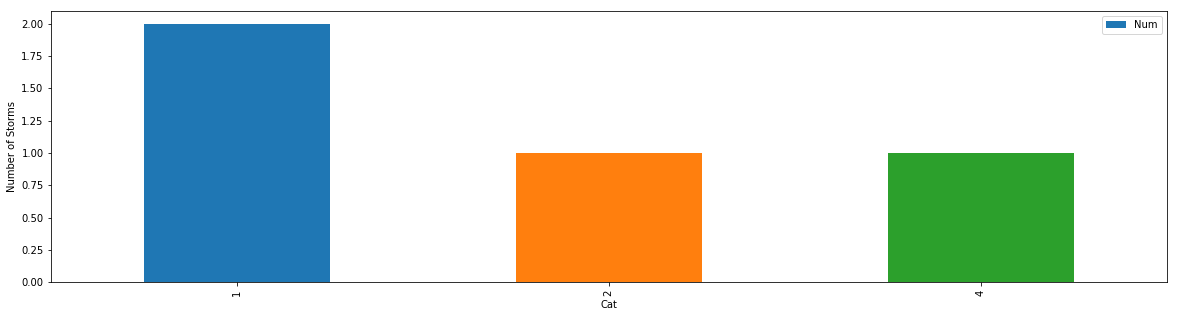

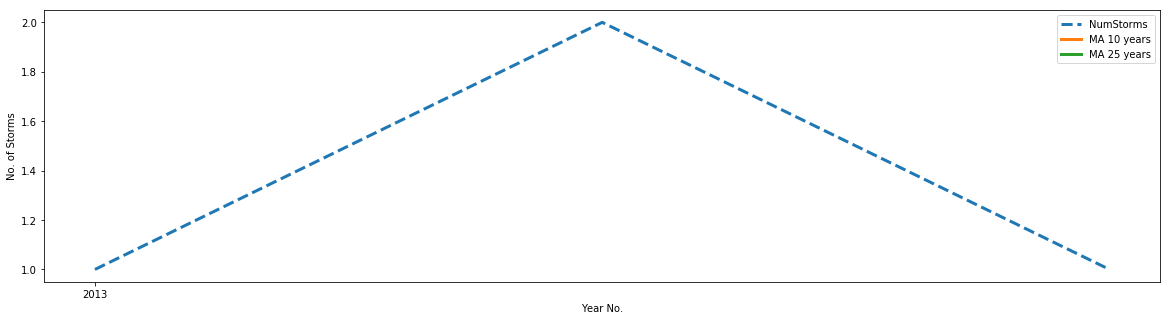

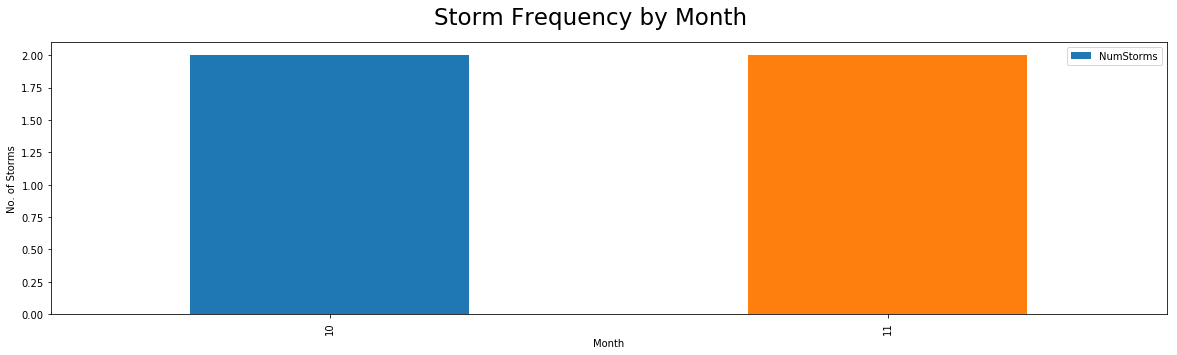

In [18]:
#from mpl_toolkits.basemap import Basemap
from pandas import DataFrame, read_csv
import pandas as pd
import numpy as np
#from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import sys

Location = r'/Users/shruthiural/Desktop/hurdata.csv' 
hurdat2 = pd.read_csv(Location)

hurdat2

plt_title = "Counting and moving averages by frequency"

StormCountByCategory(hurdat2)
HurrCyclicality(hurdat2)
HurrSeasonality(hurdat2)
#StormGenesis(hurdat2)
Calc_Trans_Prob(Grid)

In [10]:
# Count Number of Storms by Category
def StormCountByCategory(hurdat2):
  grouped = hurdat2.groupby('Cat')['StormID'].unique().to_frame().reset_index()
  grouped['Num'] = grouped['StormID'].str.len()
  grouped.plot.bar(x='Cat', y='Num')
  plt.ylabel('Number of Storms')
 # Cyclicality
def HurrCyclicality(hurdat2):
  grouped_by_year = hurdat2.groupby('Year')['StormID'].unique().to_frame().reset_index()
  grouped_by_year['NumStorms'] = grouped_by_year['StormID'].str.len()
  grouped_by_year['Year'] = grouped_by_year['Year'].astype('int')
  grouped_by_year['NumStorms'] = grouped_by_year['NumStorms'].astype('int')
  plt.rcParams["figure.figsize"] =(20,5)
  grouped_by_year.plot(x='Year', y='NumStorms',linewidth=3,linestyle = 'dashed')
  plt.xticks(np.arange(grouped_by_year.Year.min(),grouped_by_year.Year.max(),25))
  plt.ylabel('No. of Storms')
  plt.plot(grouped_by_year['Year'],grouped_by_year['NumStorms'].rolling(10).mean(),label= 'MA 10 years', linewidth=3)
  plt.plot(grouped_by_year['Year'],grouped_by_year['NumStorms'].rolling(25).mean(),label= 'MA 25 years', linewidth=3)
  plt.ylabel('No. of Storms')
  plt.xlabel('Year No.')
  plt.legend()
 
# Seasonality
def HurrSeasonality(hurdat2):
  grouped_by_month = hurdat2.groupby('Month')['StormID'].unique().to_frame().reset_index()
  grouped_by_month['NumStorms'] = grouped_by_month['StormID'].str.len()
  grouped_by_month['Month'] = grouped_by_month['Month'].astype('int')
  grouped_by_month['NumStorms'] = grouped_by_month['NumStorms'].astype('int')
  plt.rcParams["figure.figsize"] =(20,5)
  grouped_by_month.plot.bar(x='Month', y='NumStorms')
  #plt.xticks(np.arange(grouped_by_month.Year.min(),grouped_by_year.Year.max(),25))
  plt.ylabel('No. of Storms')
  plt.suptitle('Storm Frequency by Month', fontsize=23)
 # Most Frequent Storm Name
def MostFreqStormNames(hurdat2):
  UniqueStorms = hurdat2.groupby(['StormID','StormName']).size().reset_index().rename(columns={0:'NoRecordings'})
  NameFreq = UniqueStorms.StormName.value_counts().reset_index().rename(columns={'index':'StrmName', 'StormName':'StrmCount'})
  HTML(NameFreq[:10].to_html())
 # Helper function for Plotting Maps
def MapTemplate(plt_title):
  plt.figure(figsize=(10, 8))
  m1 = Basemap(llcrnrlon=-100.,llcrnrlat=0.,urcrnrlon=30.,urcrnrlat=57.,projection='lcc',lat_1=20.,lat_2=40.,lon_0=-60.,resolution ='l',area_thresh=1000.)    
  m1.drawcoastlines()
  m1.drawparallels(np.arange(10,70,10),labels=[1,1,0,0])
  m1.drawmeridians(np.arange(-100,0,10),labels=[0,0,0,1])
  plt.suptitle(plt_title, fontsize=16)
  return m1
 # Storm Track of All Storms in Atlantic Basin
def AllStormTracks(hurdat2):
  m1 = MapTemplate("Atlantic Hurricane Historical Storms (1851-2014)")
  UniqueStorms = hurdat2.StormID.unique()
  for stormid, track in hurdat2.groupby('StormID'):
      lat_storm = track.Lat.values
      lon_storm = track.Lon.values
      x1, y1 = m1(lon_storm,lat_storm)
      plt.plot(x1,y1,'r-',linewidth=0.5)
  plt.title('Total Number of Storms = '+ str(len(UniqueStorms)))
  
# Storm Track of All Storms in Atlantic Basin
def LandFallingStormTracks(hurdat2):
  m = MapTemplate("Atlantic Hurricane : Landfalling Historical Storms (1851-2014)")
  LandfallStorms = hurdat2[hurdat2.RecIdentifier == " L"]
  LandfallStorms_Unique = LandfallStorms.StormID.unique()
  print ('Total number of Landfalling Storms = ', len(LandfallStorms_Unique))
  for stormid in LandfallStorms_Unique:
      temp_db = hurdat2[hurdat2.StormID == stormid]
      lat_storm = temp_db.Lat.values
      lon_storm = temp_db.Lon.values
      x1, y1 = m(lon_storm,lat_storm)
      plt.plot(x1,y1,'g-',linewidth=0.5)
  plt.title('Total Number of Storms = '+ str(len(LandfallStorms_Unique)))
 # Storm Track of All Storms in Atlantic Basin
def StormGenesis(hurdat2):
  m = MapTemplate("Atlantic Hurricane Storm Genesis (1851-2014)")
  UniqueStorms = hurdat2.StormID.unique()
  Genesis = hurdat2.groupby('StormID').first()
  longitude = Genesis.Lon.values
  latitude = Genesis.Lat.values
  cat = Genesis.Cat.values
  x, y = m(longitude, latitude)
  plt.scatter(x,y,color='m',marker='D',s=4)
  plt.title('Total Number of Unique Storms = %d' % (len(UniqueStorms))) 

In [17]:
# Calculate Transition Probabilities
def Calc_Trans_Prob(Grid):
    MasterGridLookup = {}
    MasterTransProb = {}
    for index, row in Grid.iterrows():
        result = {index:[]}
        prob = {index:[]}
        x_coord = row.Lon
        y_coord = row.Lat
        total = 0.0
        temp = [(-1,1),(-1,0),(-1,-1),(0,1)]
        for x, y in [(x_coord+i, y_coord+j) for i, j in temp]:
            temp = '('+str(x)+', '+str(y)+')'
            MatchGrid = Grid[Grid.Cell.astype(str).str.contains(temp)]
            if (MatchGrid.shape[0] == 1):
                result[index].append(MatchGrid.GridID.values.tolist()[0])
                prob[index].append(MatchGrid.CountHits.values.tolist()[0])
                total = total + MatchGrid.CountHits.values.tolist()[0]
        if total > 0.0:
            norm_prob = np.array(list(prob.values())).flatten()/total
            prob[index] = norm_prob.tolist()
        
        MasterGridLookup.update(result)
        MasterTransProb.update(prob)
    return MasterGridLookup, MasterTransProb
  
def TrackSim(NoOfSim, NoOfSimPoints, Grid, EventData,MasterGridLookup, MasterTransProb):
    #Create a KD Tree to check for nearest grid point
    gridpts_tree = spatial.KDTree(Grid.Cell.tolist())

    SimPath = pd.DataFrame(columns=['Sim','Epoch','Lon','Lat'])
    SimPath['Sim'] = np.repeat(np.arange(NoOfSim),NoOfSimPoints)
    SimPath['Epoch'] = list(np.arange(NoOfSimPoints))*NoOfSim
    SimPath.set_index(['Sim', 'Epoch'],inplace=True)
    #HTML(SimPath.head().to_html())

    for sim in range(NoOfSim):
        for i in range(NoOfSimPoints-1):
            #print (sim,i)
            if i == 0:
                GridIdx = gridpts_tree.query([(EventData.Lon.values[0], EventData.Lat.values[0])])[1]
                SimPath.loc[sim,i]['Lon'] = EventData.Lon.values[0]
                SimPath.loc[sim,i]['Lat'] = EventData.Lat.values[0]
            else:
                GridIdx = gridpts_tree.query([(NextCell_Lon, NextCell_Lat)])[1]

            #Use the closest grid point index to find the corresponding GridID
            GridID_Val = Grid.iloc[GridIdx]['GridID'].values[0]

            #Neighbor grids and transition probabilities
            TransProb = MasterTransProb[GridID_Val]
            CumTransProb = np.cumsum(TransProb)

            if sum(CumTransProb) > 0:
                cell_direction = np.random.choice(np.arange(0,len(TransProb)), p=TransProb)
                NextCell_idx = MasterGridLookup[GridID_Val][cell_direction]
                NextCell_Lon = Grid.ix[NextCell_idx]['Lon']
                NextCell_Lat = Grid.ix[NextCell_idx]['Lat']
                SimPath.loc[sim,i+1]['Lon'] = NextCell_Lon
                SimPath.loc[sim,i+1]['Lat'] = NextCell_Lat
            else:
                SimPath.loc[sim,i+1]['Lon'] = SimPath.loc[sim,i]['Lon']
                SimPath.loc[sim,i+1]['Lat'] = SimPath.loc[sim,i]['Lat']
    return SimPath
 
def PlotStochTrack(HistPath, StochPath, plt_title):
    MapTemplate(plt_title)
    for stormid, track in HistPath.groupby('StormID'):
        lat_kat = track.Lat.values
        lon_kat = track.Lon.values
        x1, y1 = m1(lon_kat,lat_kat)
        plt.plot(x1,y1,'-',label=stormid,linewidth=2,color='black')

    for stormid, track in StochPath.groupby('Sim'):
        lat_kat = track.Lat.values
        lon_kat = track.Lon.values
        poly = np.polyfit(list(lon_kat), list(lat_kat), 5)
        poly_lat = np.poly1d(poly)(lon_kat)
        poly_lat[0] = lat_kat[0]
        x1, y1 = m1(lon_kat,poly_lat)
        plt.plot(x1,y1,'-',label=stormid,linewidth=2)
    
    plt.legend()

Landfall windspeed for Florence 116.745 mph


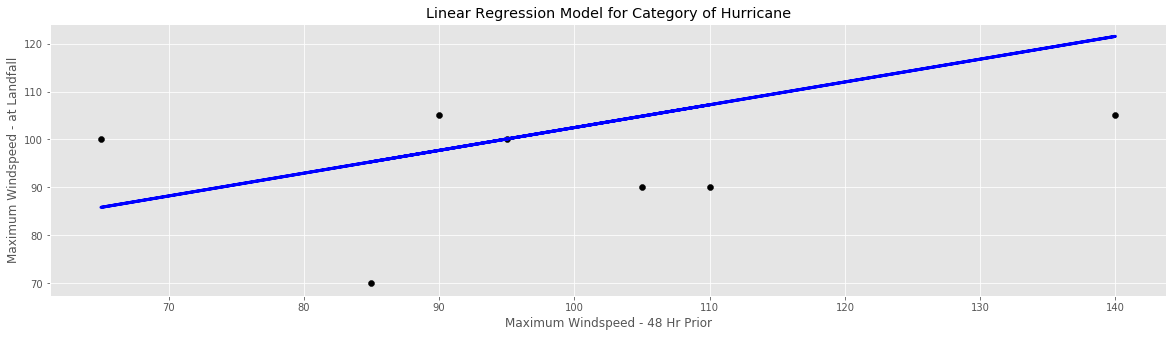

In [168]:
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create linear regression object
regr = linear_model.LinearRegression()

#load csv file with pandas
Location = r'Windspeed.csv' 
df = pd.read_csv(Location)

#Fetch maximum wind speed 48 hour prior to landfall
x = df['Maximum Wind']
#Fetch windspeed at landfall
y= df['Landfall Wind']

x = x.values.reshape(-1, 1)
x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.25, random_state=0)

# Train the model using the training sets
regr.fit(x_train, y_train)
X_new = np.array(df['Maximum Wind']).reshape(-1, 1)

regr.predict(X_new)
# Make predictions using the testing set
y_pred = regr.predict(x_test)
#predict windspeed for florence based on 48 hr prior wind speed - 130mph
y_pred1 = regr.predict([[130]])
y_pred1 = y_pred1[0]
print "Landfall windspeed for Florence " + str(format(y_pred1, '.3f')) + " mph"

fig,ax = plt.subplots()

# Plot outputs
plt.title("Linear Regression Model for Category of Hurricane")
plt.scatter(x_test, y_test,  color='black')
plt.plot(x_test, y_pred, color='blue', linewidth=3)

ax.set_xlabel('Maximum Windspeed - 48 Hour Prior Landfall')
ax.set_ylabel('Maximum Windspeed - at Landfall')

plt.show()

In [90]:
 
import matplotlib
 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import seaborn as sns
from matplotlib import style

style.use("ggplot")
from sklearn import svm
 
# Load CSV and columns
Location = r'/Users/shruthiural/desktop/testing.csv' 
df = pd.read_csv(Location)

X = ['Maximum Wind']
print(X)
y = ['Cat']
X = X[y!=0,:2]
y
X = np.array([df['Maximum Wind'],df['Cat']])
y = [0,1,0,1,0,1,0,1]
print(X)
print(y)

plt.scatter(X,y)
plt.show()

#X = scaler.inverse_transform(X.reshape(-1,1))
#X= X.reshape[1,-1]

#X = X.reshape(X.shape[1:])

#X = X.tranpose() 

#clf = svm.SVC(kernel='linear', C = 1.0)
#clf.fit(X,y)

#print(clf.predict([75.1]))


# X_train,X_test,y_train,y_test = train_test_split(X,y,random_state =0)

# knn = KNeighborsClassifier(n_neighbors = 5)

# knn.fit(X_train,y_train)

# print("Accuracy:",knn.score(X_test,y_test))

# example_data=  [[75.1]]

# print("predict_cat_for",example_data,knn.predict(example_data))
 

['Maximum Wind']


TypeError: list indices must be integers, not tuple

In [32]:
# Create linear regression object
regr = linear_model.LinearRegression()
 
# Train the model using the training sets
regr.fit(X_train, Y_train)
 
# Plot outputs
plt.plot(X_test, regr.predict(X_test), color='red',linewidth=3)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.